In [1]:
!pip install uproot awkward 
from uproot_io import Events, View
import numpy as np
import matplotlib.pyplot as plt
import features as f
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.smoothers_lowess import lowess
import random

In [2]:
cheated_0 = Events('CheatedRecoFile_0.root')
sliced_0 = f.slice_events(cheated_0)
cheated_0_candidates = f.identify_candidate(cheated_0)
showers_0 = [r[1] for r in cheated_0_candidates if not cheated_0.is_true_track[r[1]]]
print(f'There are {len(showers_0)} candidate showers in cheated_0')

Events sliced, 499617 events split across 9505 unique event ids
There are 4767 candidate showers in cheated_0


In [3]:
# Now lets look at different ways of approximating the vertex. Perhaps we find a few and take an average?

def dbscan_vertex(w_hits, x_hits, eps=5, min_samples=10):
    """Finds the densest region using DBSCAN clustering to approximate the branch vertex."""
    points = np.column_stack((w_hits, x_hits))
    
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
    
    # Find the most populated cluster
    labels, counts = np.unique(clustering.labels_, return_counts=True)
    main_cluster_label = labels[np.argmax(counts[labels >= 0])]  # Ignore noise (-1 label)

    # Get the centroid of this cluster
    main_cluster_points = points[clustering.labels_ == main_cluster_label]
    w_vertex, x_vertex = np.mean(main_cluster_points, axis=0)

    return w_vertex, x_vertex

from sklearn.decomposition import PCA

def pca_vertex(w_hits, x_hits):
    """Finds the vertex using PCA by projecting points onto the first principal component."""
    points = np.column_stack((w_hits, x_hits))
    
    pca = PCA(n_components=2)
    pca.fit(points)

    # Project points onto the first principal component
    projected = np.dot(points - pca.mean_, pca.components_.T)

    # Vertex is the point closest to the start of the principal component
    min_idx = np.argmin(projected[:, 0])  # Find the smallest projection (starting point)
    return [w_hits[min_idx], x_hits[min_idx]]

def curvature_vertex(w_hits, x_hits, window_size=5):
    """Finds the vertex by detecting the point with the highest local curvature."""
    w_hits, x_hits = np.array(w_hits), np.array(x_hits)
    curvatures = np.zeros(len(w_hits))

    for i in range(window_size, len(w_hits) - window_size):
        # Compute local differences
        dx1 = w_hits[i] - w_hits[i - window_size]
        dy1 = x_hits[i] - x_hits[i - window_size]
        dx2 = w_hits[i + window_size] - w_hits[i]
        dy2 = x_hits[i + window_size] - x_hits[i]

        # Compute angle change (curvature proxy)
        dot_product = dx1 * dx2 + dy1 * dy2
        norm1 = np.sqrt(dx1**2 + dy1**2)
        norm2 = np.sqrt(dx2**2 + dy2**2)

        if norm1 * norm2 > 0:
            value = dot_product / (norm1 * norm2)
            value = np.clip(value, -1, 1)  # Fix: Clamp value to avoid invalid arccos
            curvatures[i] = np.arccos(value)

    # The vertex is at the max curvature
    max_curvature_idx = np.argmax(curvatures)
    return [w_hits[max_curvature_idx], x_hits[max_curvature_idx]]

import networkx as nx
from scipy.spatial import distance_matrix

def mst_vertex(w_hits, x_hits):
    """Finds the vertex by constructing a Minimum Spanning Tree (MST) and detecting high-degree nodes."""
    points = np.column_stack((w_hits, x_hits))
    
    # Compute distance matrix
    dist_matrix = distance_matrix(points, points)

    # Construct a graph and compute MST
    G = nx.Graph()
    for i in range(len(points)):
        for j in range(i + 1, len(points)):
            G.add_edge(i, j, weight=dist_matrix[i, j])

    mst = nx.minimum_spanning_tree(G)

    # Find the highest-degree node (potential vertex)
    degrees = dict(mst.degree())
    vertex_idx = max(degrees, key=degrees.get)

    return [w_hits[vertex_idx], x_hits[vertex_idx]]


In [14]:
# Approach was wrong, need to find branch vertex yes, but the points needed must be from shower vertex until branch vertex, not afterwards.

def dEdx_points(events, event_idx, cone_angle, show_plot=False):
    w_hits = events.reco_hits_w[event_idx]

    # Quality Check
    if not len(w_hits) > 15:
        print('Does not meet 15 hit cutoff')
        return None
        
    x_hits = events.reco_hits_x_w[event_idx]
    w_vtx = events.neutrino_vtx_w[event_idx]
    x_vtx = events.neutrino_vtx_x[event_idx]
    
    pdg = events.mc_pdg[event_idx]
    c_class = 'b'
    event = 'ERROR: Not e/gamma'
    
    if pdg in [-11, 11]:
        c_class = '#EEEE00'
        event = 'Electron'
    elif pdg == 22:
        c_class = 'g'
        event = 'Photon'

    # Convert hits to array
    data = np.column_stack((w_hits, x_hits))

    # DBSCAN Clustering (eps: search radius, min_samples: min points per cluster)
    dbscan = DBSCAN(eps=2, min_samples=2).fit(data)
    labels = dbscan.labels_
    unique_labels = set(labels)

    # Separate noise and clustered points
    noise_mask = labels == -1
    clustered_mask = labels != -1
    noise_points = data[noise_mask]
    clustered_points = data[clustered_mask]

    w_clustered = clustered_points[:, 0]
    x_clustered = clustered_points[:, 1]

    if len(w_clustered) == 0 or len(x_clustered) == 0:
        print('Clustered hits are empty')
        return None

    # Get a smoothed plot
    smoothed = lowess(x_clustered, w_clustered, 0.3)

    # make the validity cone
    slope, _ = np.polyfit(w_hits, x_hits, 1)
    theta_0 = np.arctan2(slope, 1)
    theta_u = theta_0 + cone_angle/2
    theta_l = theta_0 - cone_angle/2

    # Length of lines
    r = 30  # Adjust as needed
    
    # Compute line endpoints
    direction = 1
    if np.mean(w_hits) < w_vtx:
        direction = -1
    w_u = w_vtx + r * np.cos(theta_u) * direction
    x_u = x_vtx + r * np.sin(theta_u) * direction
    
    w_l = w_vtx + r * np.cos(theta_l) * direction
    x_l = x_vtx + r * np.sin(theta_l) * direction
    
    # Branch Vertex Algorithms
    #branch_vtx_pca = pca_vertex(w_clustered, x_clustered)
    #branch_vtx_curvature = curvature_vertex(w_clustered, x_clustered)
    branch_vtx_mst = mst_vertex(w_clustered, x_clustered)

    #branch_vertices = np.array([branch_vtx_pca, branch_vtx_curvature, branch_vtx_mst])
    #branch_vertex = tuple(np.mean(branch_vertices, axis=0))

    angles = np.arctan2(x_clustered - x_vtx, w_clustered - w_vtx)
    distance = [np.sqrt((w - w_vtx)**2 + (x - x_vtx)**2) for (w, x) in clustered_points]
    branch_distance = np.sqrt((branch_vtx_mst[0] - w_vtx)**2 + (branch_vtx_mst[1] - x_vtx)**2)
    mask = None
    if direction == -1:
        mask = (theta_u <= angles) & (angles <= theta_l) & (distance < branch_distance)
    else: mask = (theta_l <= angles) & (angles <= theta_u) & (distance < branch_distance)

    #if not show_plot:
    #    return branch_vertex
    
    # Plot results
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))  # 1 row, 2 columns
    ax[0].scatter(w_vtx, x_vtx, c='r', marker='x', s=35, label='Neutrino vtx')
    
    # Plot noise separately
    if len(noise_points) > 0:
        ax[0].scatter(noise_points[:, 0], noise_points[:, 1], s=8, facecolor='white', edgecolor='k', label='Noise', marker='s')
    
    # Plot clustered points
    if len(clustered_points) > 0:
        # Event plot
        ax[0].scatter(w_clustered, x_clustered, s=3, c=c_class, label=f'Clustered Hits, {event}')
        ax[0].plot(smoothed[:, 0], smoothed[:, 1], c='orange', label='LOWESS Smooth plot', linewidth=1)

        #Branch Vertices
        #ax[0].scatter(branch_vtx_pca[0], branch_vtx_pca[1], marker='x', s=35, label='pca Vertex')
        #ax[0].scatter(branch_vtx_curvature[0], branch_vtx_curvature[1], marker='x', s=35, label='Curvature Vertex')
        ax[0].scatter(branch_vtx_mst[0], branch_vtx_mst[1], marker='x', s=35, label='mst Vertex')
        #ax[0].scatter(branch_vertex[0], branch_vertex[1], facecolors='none', edgecolors='purple', linewidth=1, marker='o', s=50, label='Vertex Mean')
        
        # Plot the lines
        ax[0].plot([w_vtx, w_u], [x_vtx, x_u], 'b--')  # Upper line
        ax[0].plot([w_vtx, w_l], [x_vtx, x_l], 'b--', label='Validity Cone')  # Lower line
        ax[0].set_title(f'Noise Reduction Plot; idx: {event_idx}. Event is a {event}')
        ax[0].set_ylabel('X (W View)')
        ax[0].set_xlabel('W (Wire Position)')
        ax[0].legend()
        ax[0].grid(True)

        ax[1].scatter(w_vtx, x_vtx, c='r', marker='x', s=25, label='Neutrino vtx')
        ax[1].scatter(w_hits, x_hits, s=3, c='grey', label='Hits')
        ax[1].scatter(w_clustered[mask], x_clustered[mask], s=5, c='purple', label='Identified Points')
        ax[1].legend()
        ax[1].grid(True)

    #return branch_vertex

Does not meet 15 hit cutoff
Does not meet 15 hit cutoff
Does not meet 15 hit cutoff


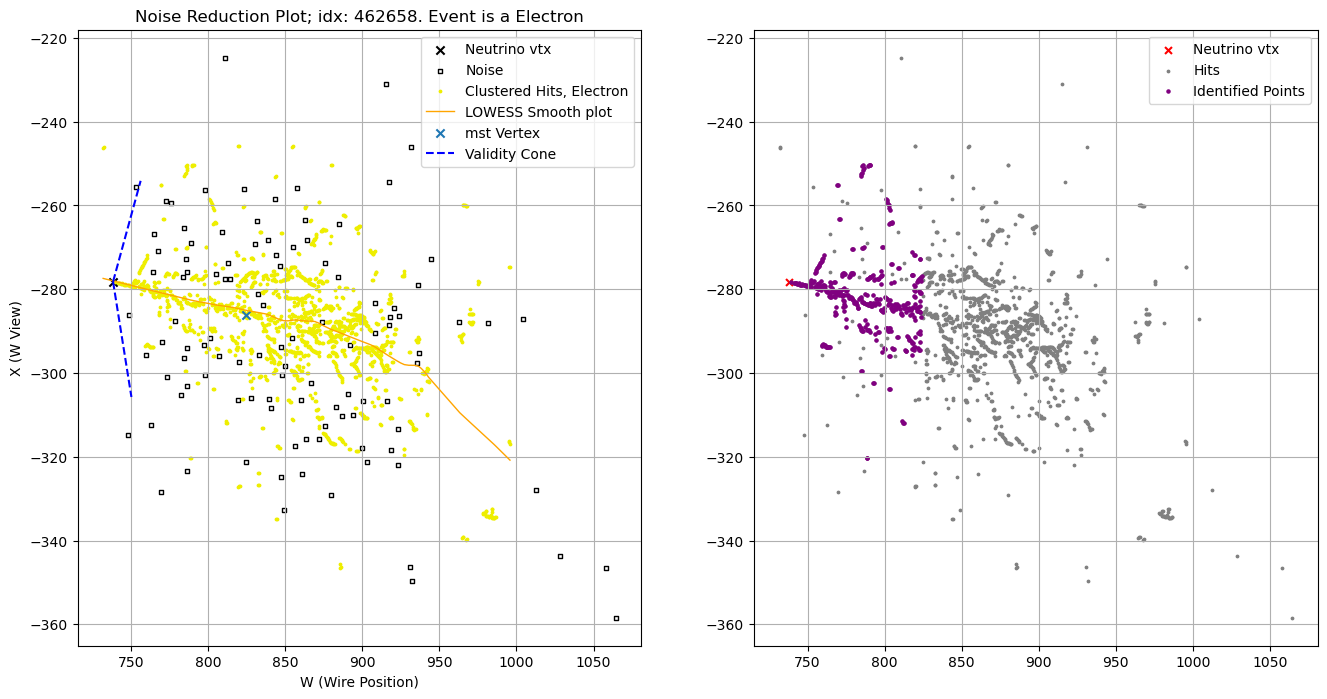

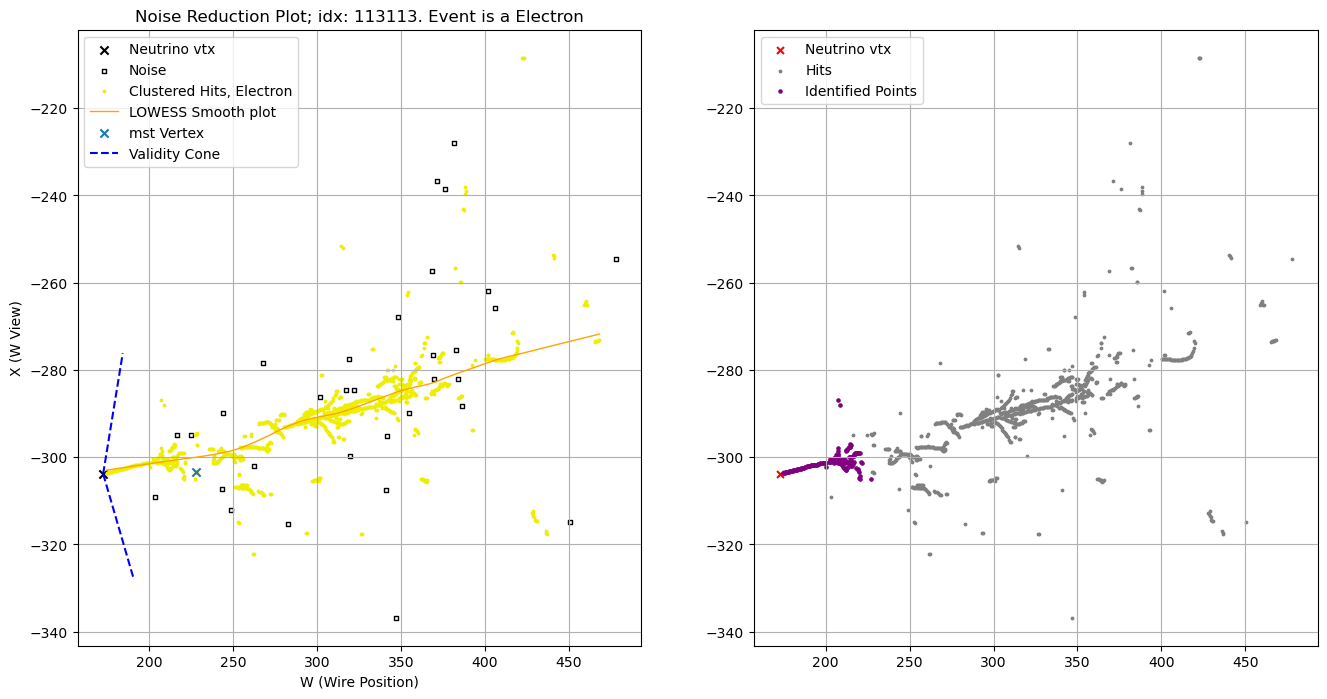

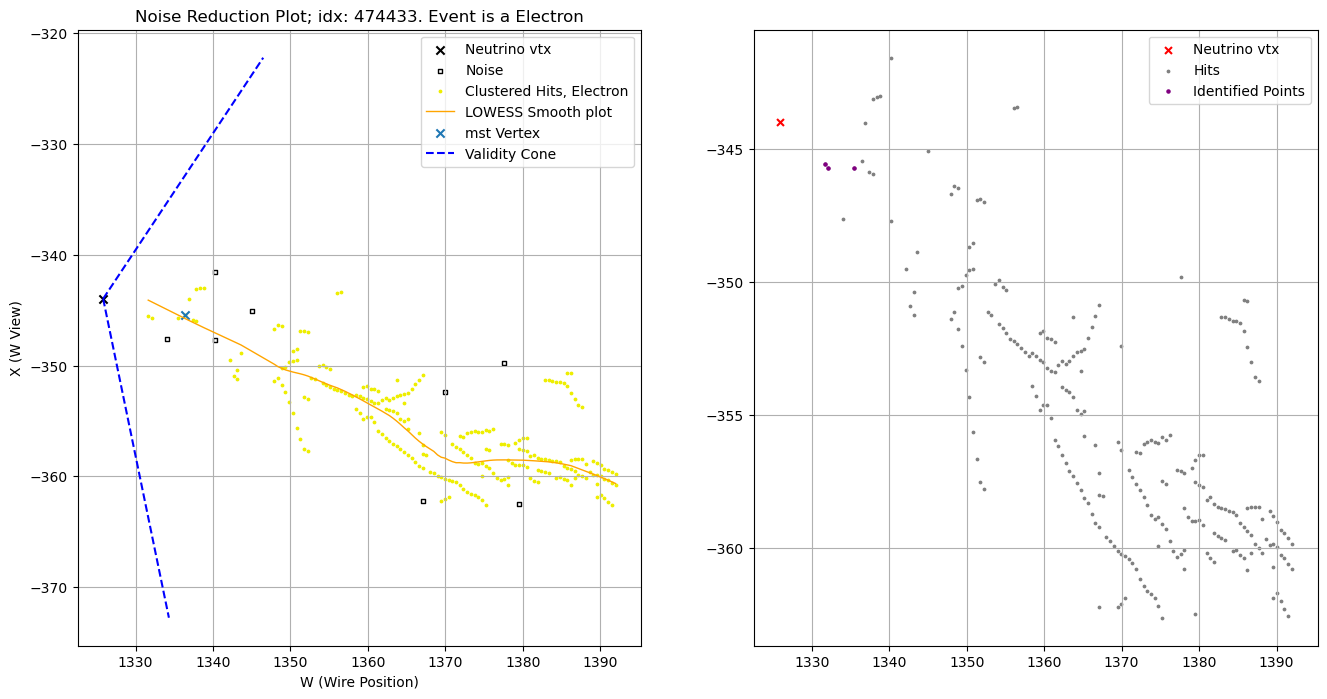

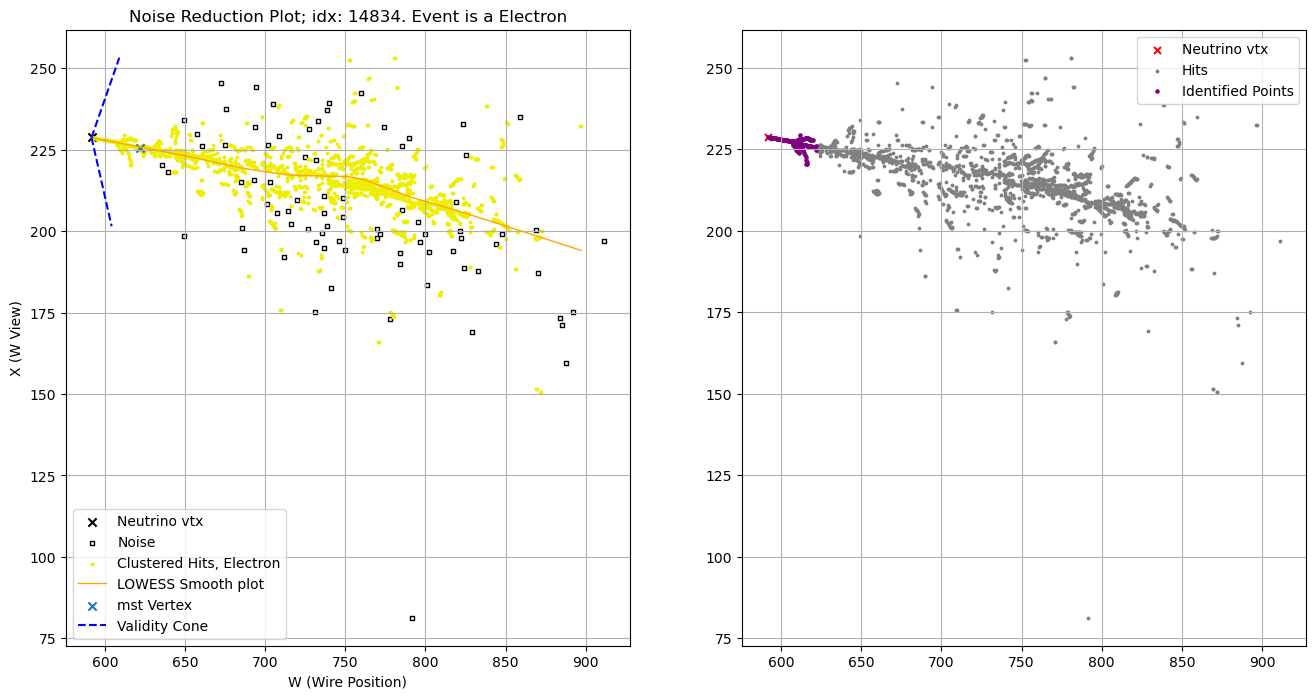

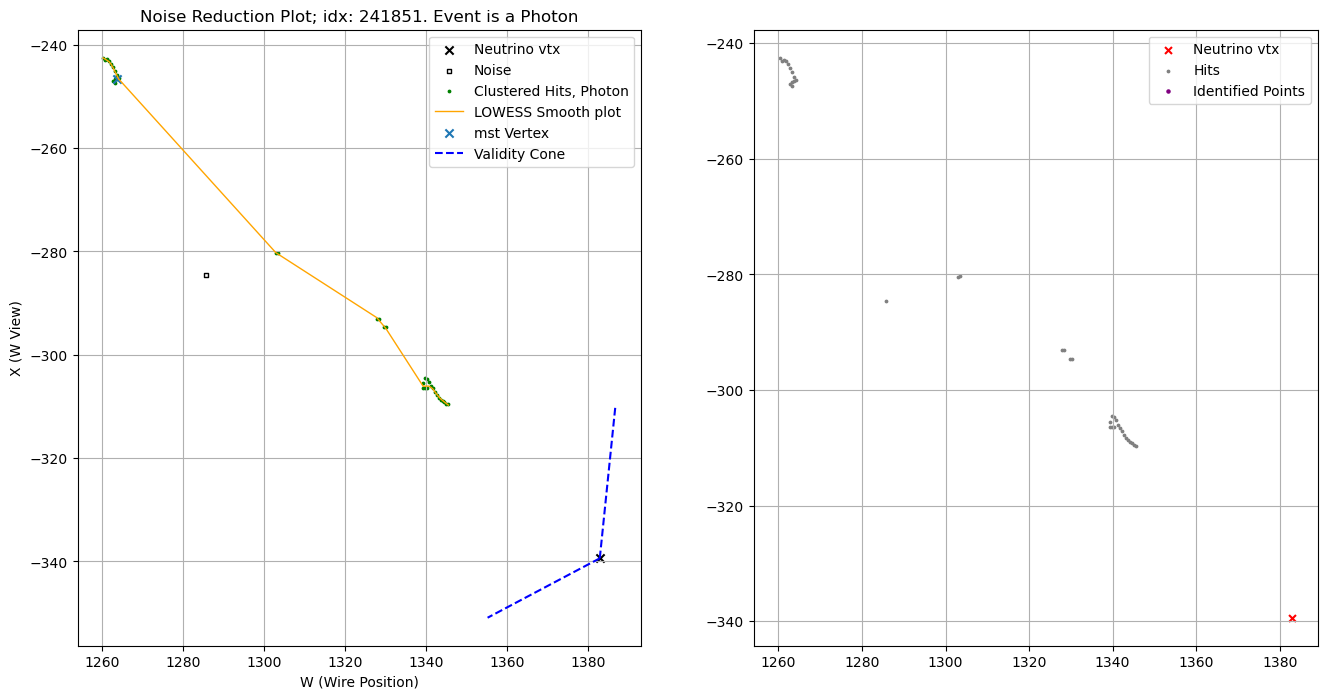

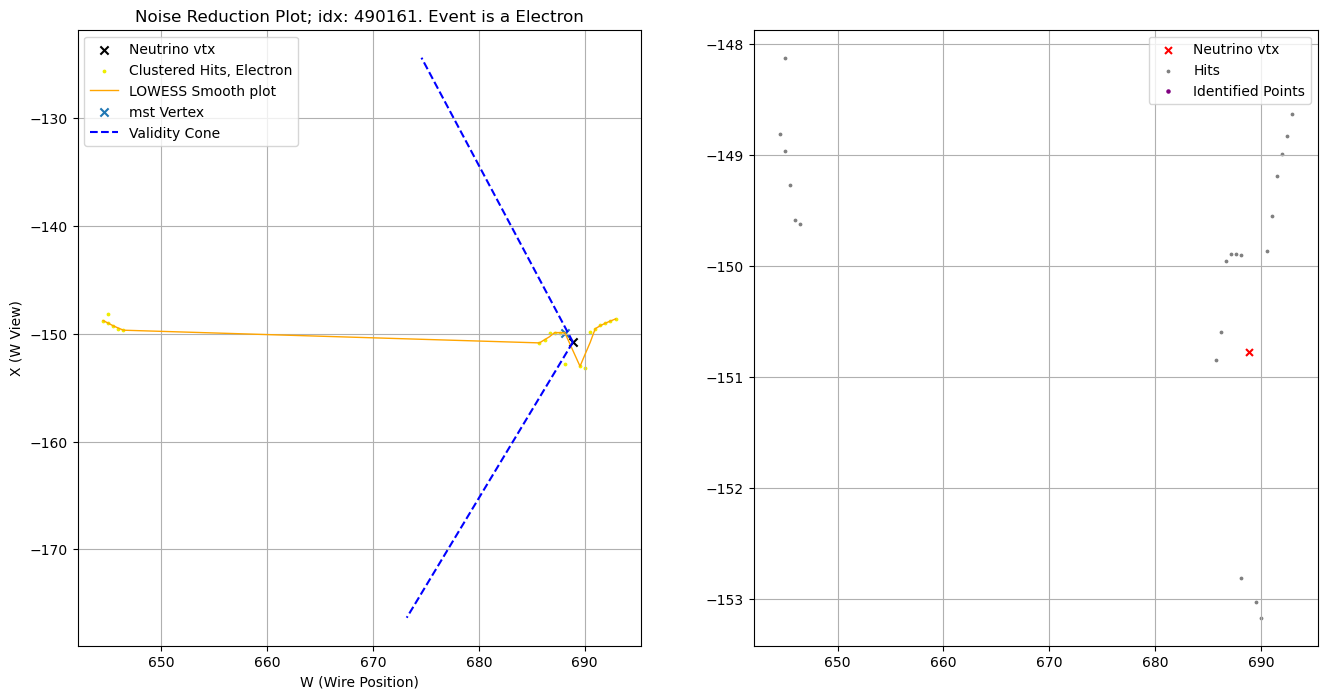

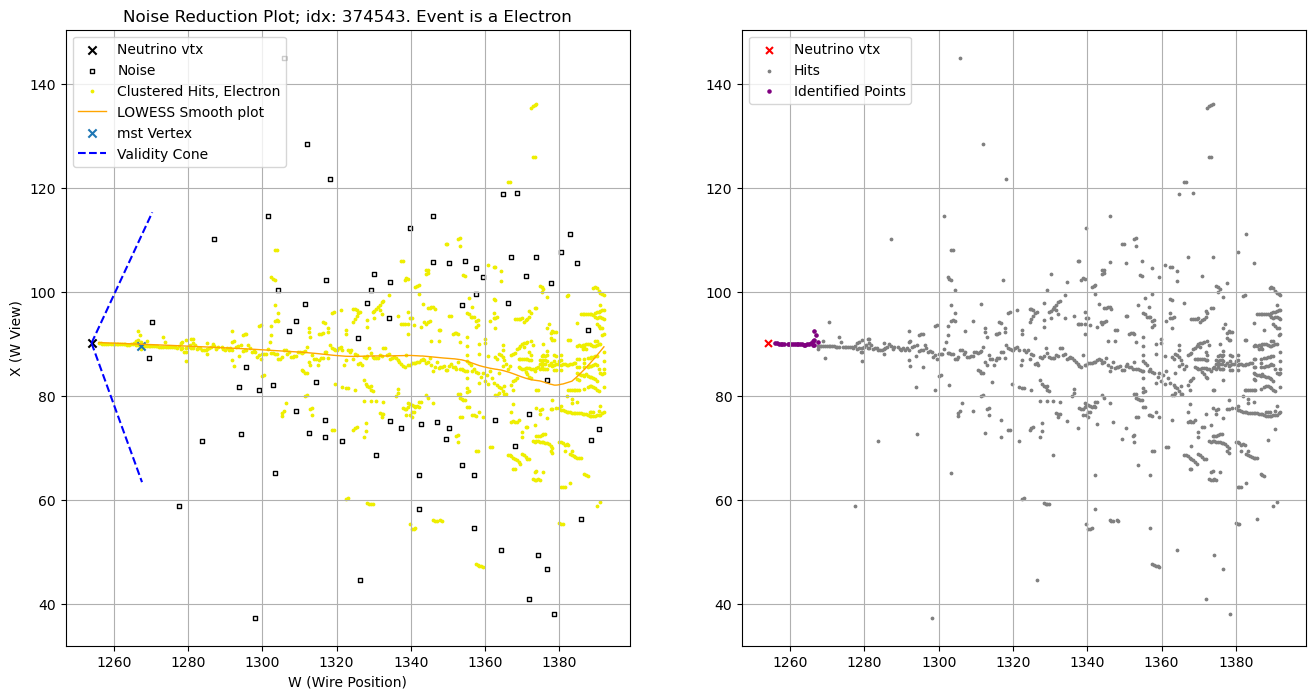

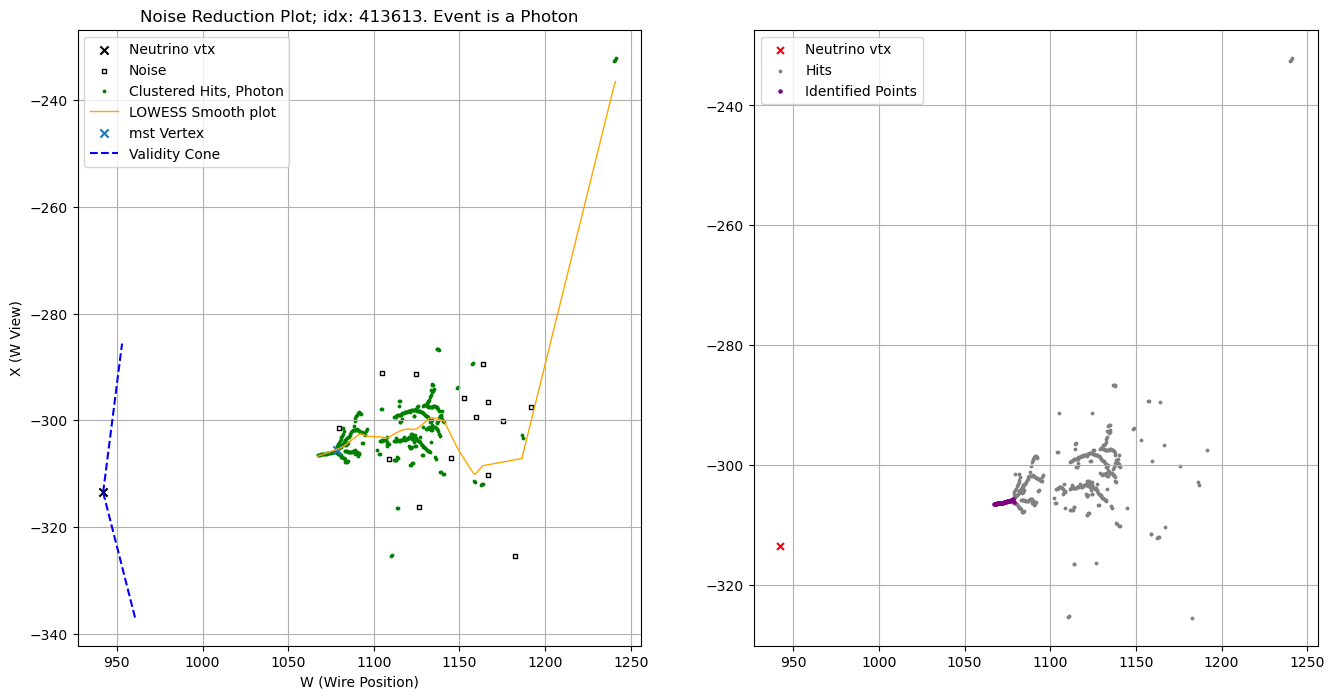

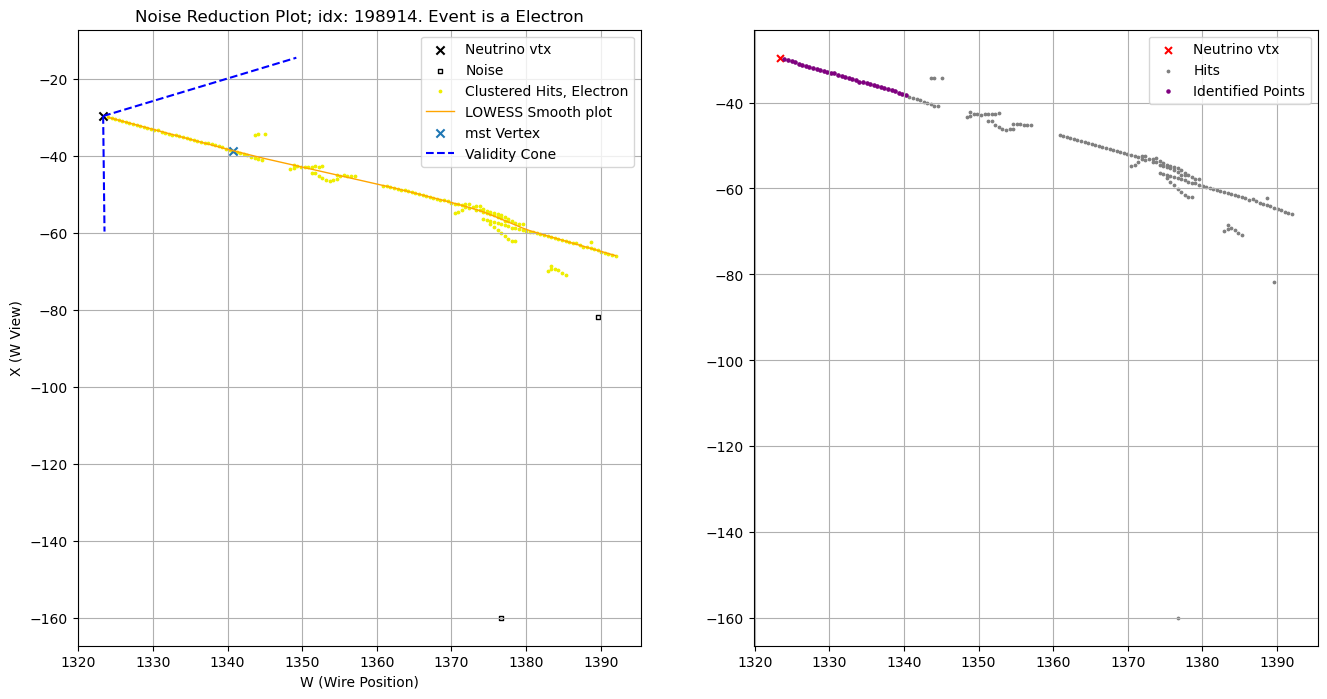

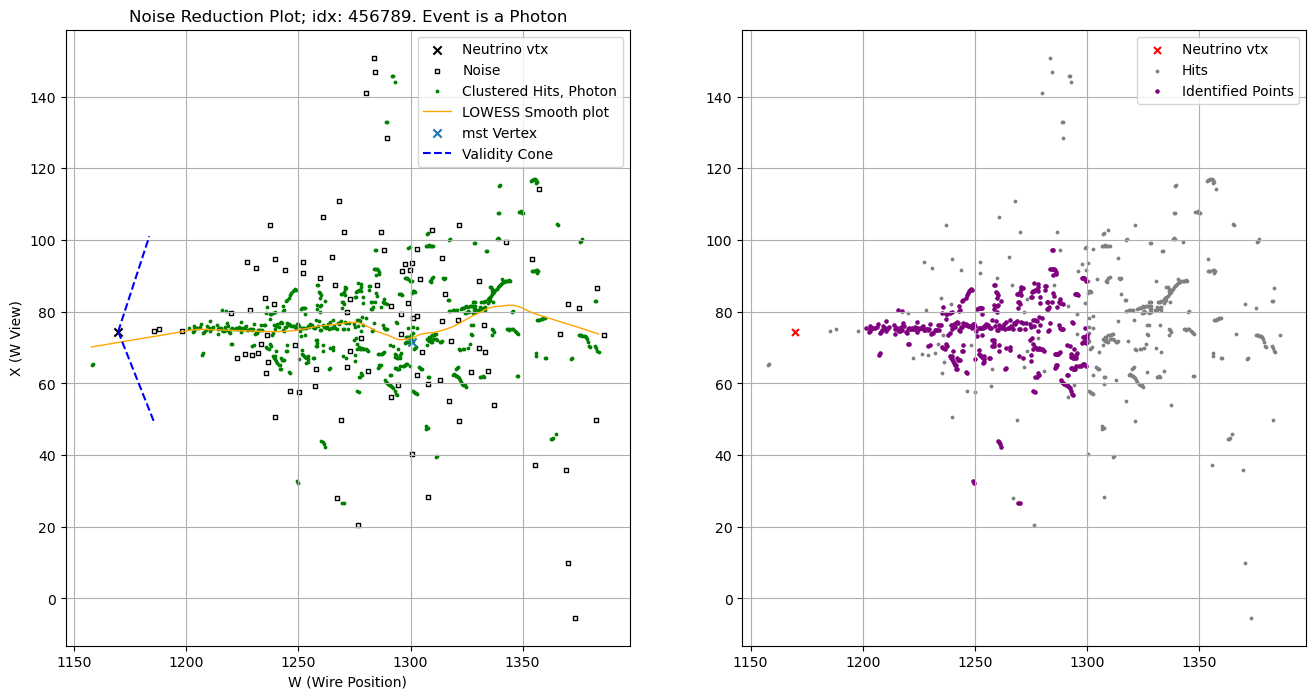

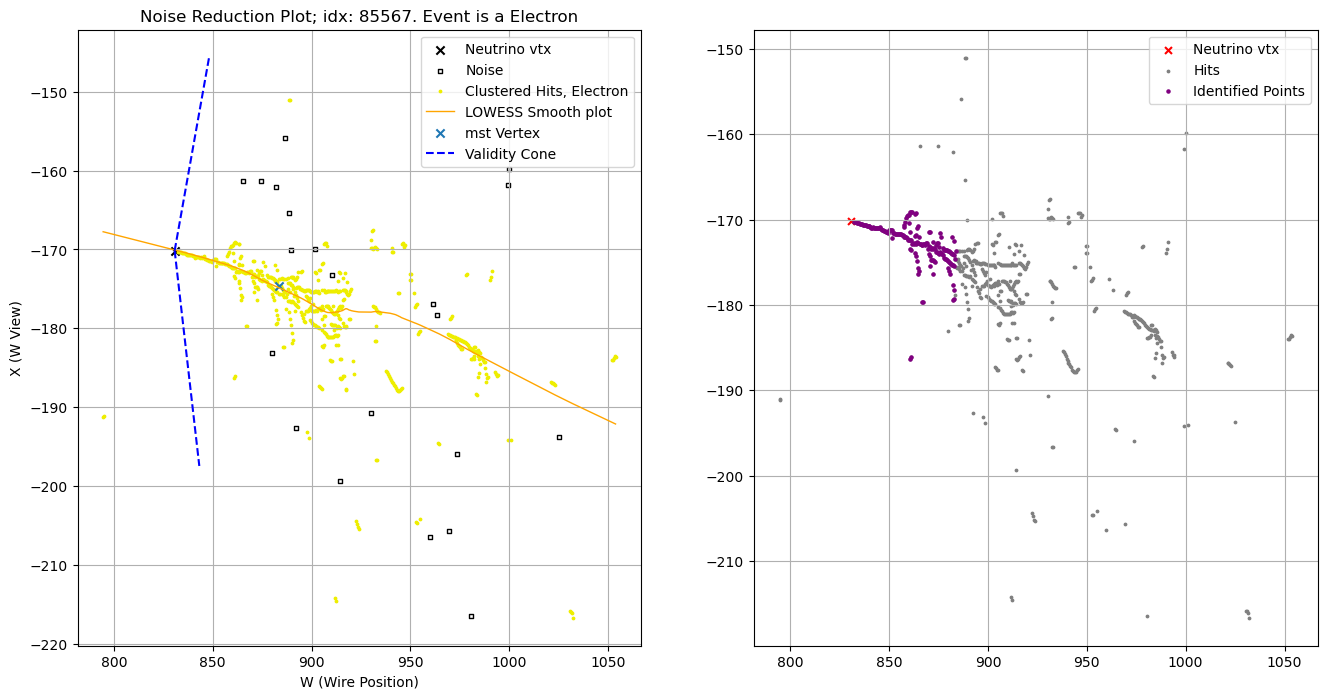

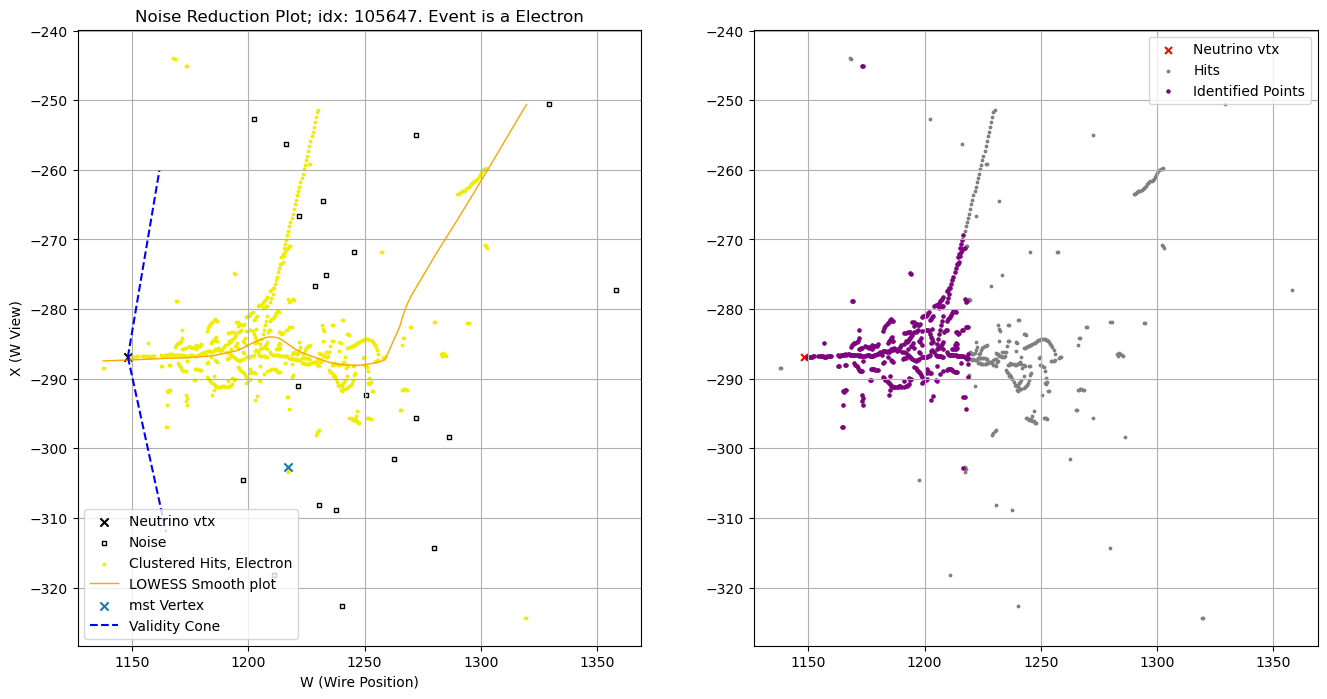

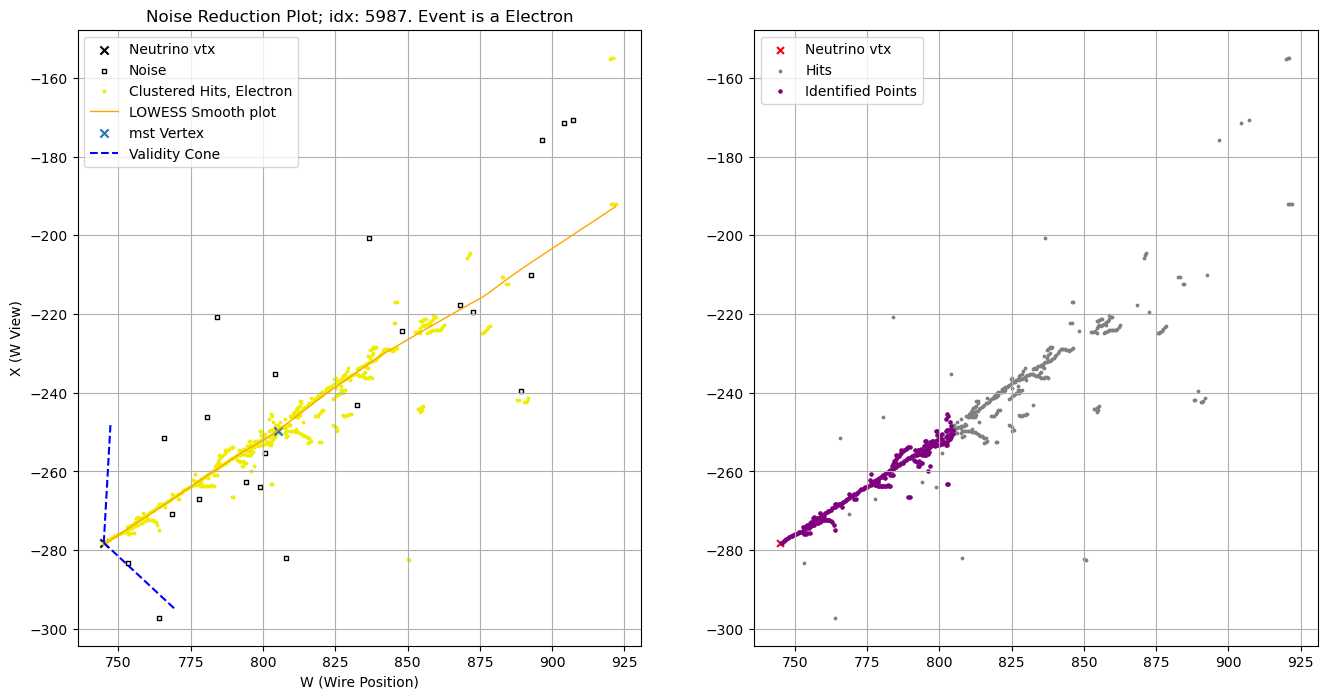

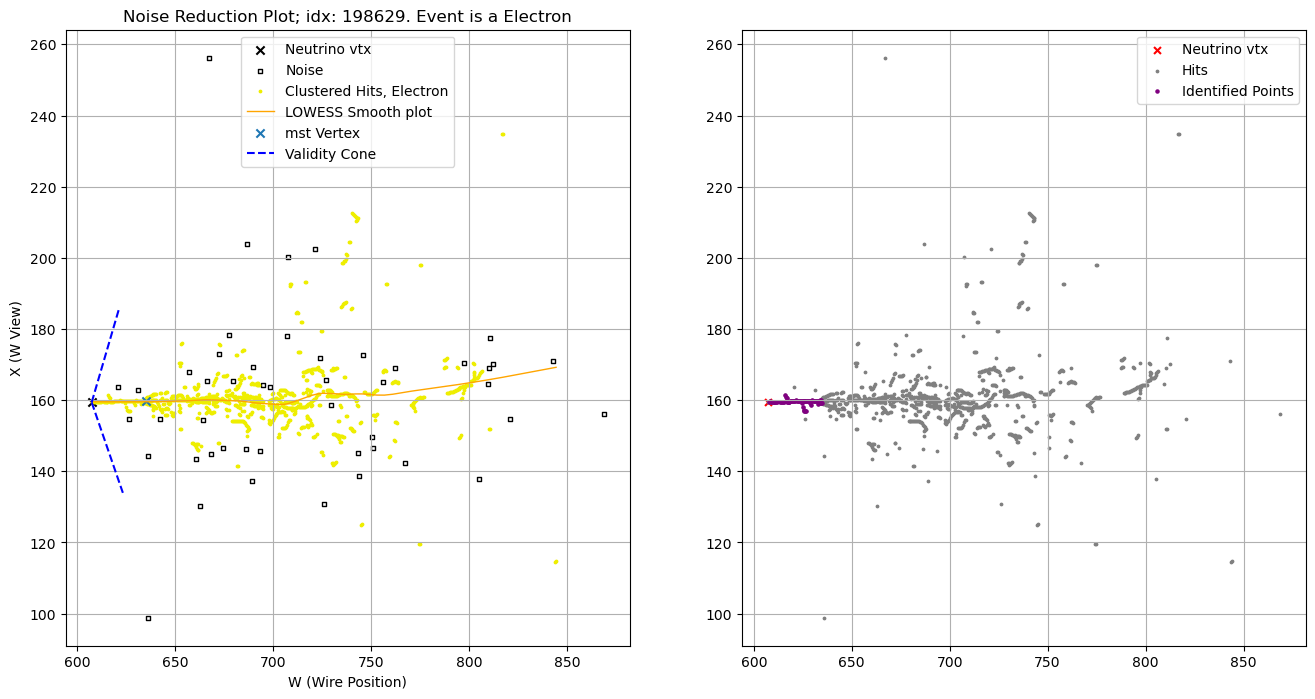

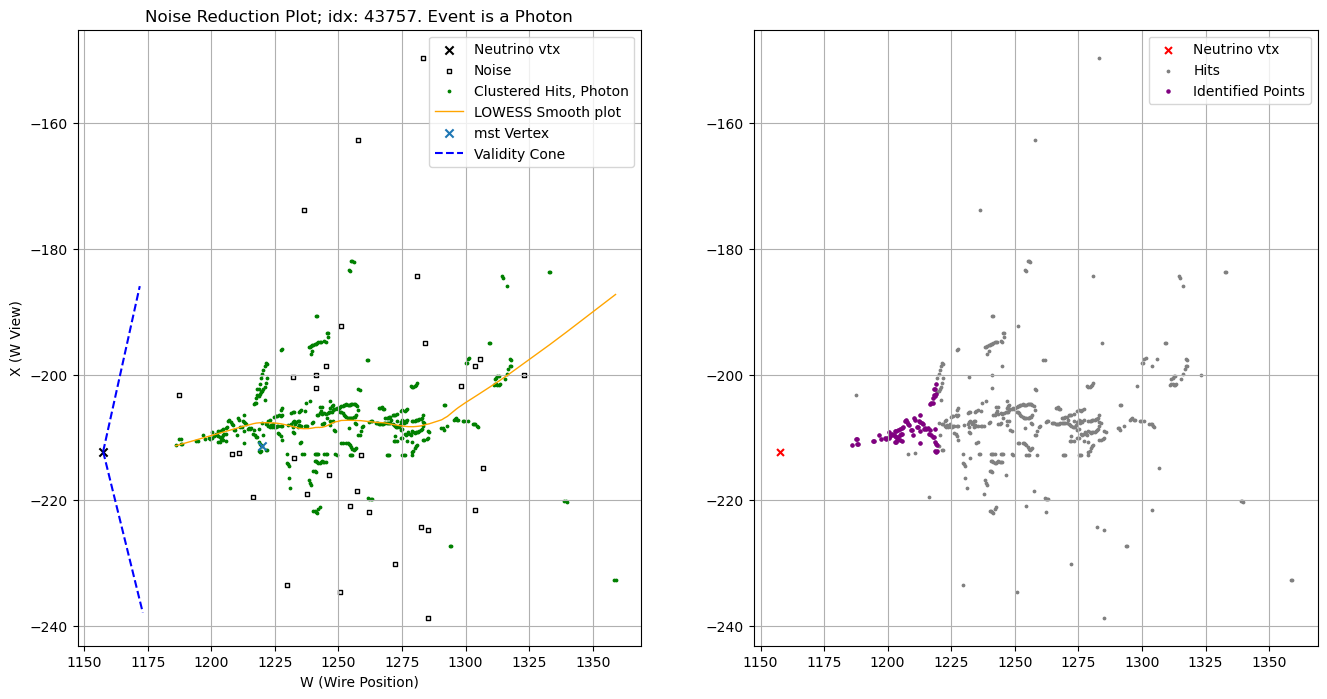

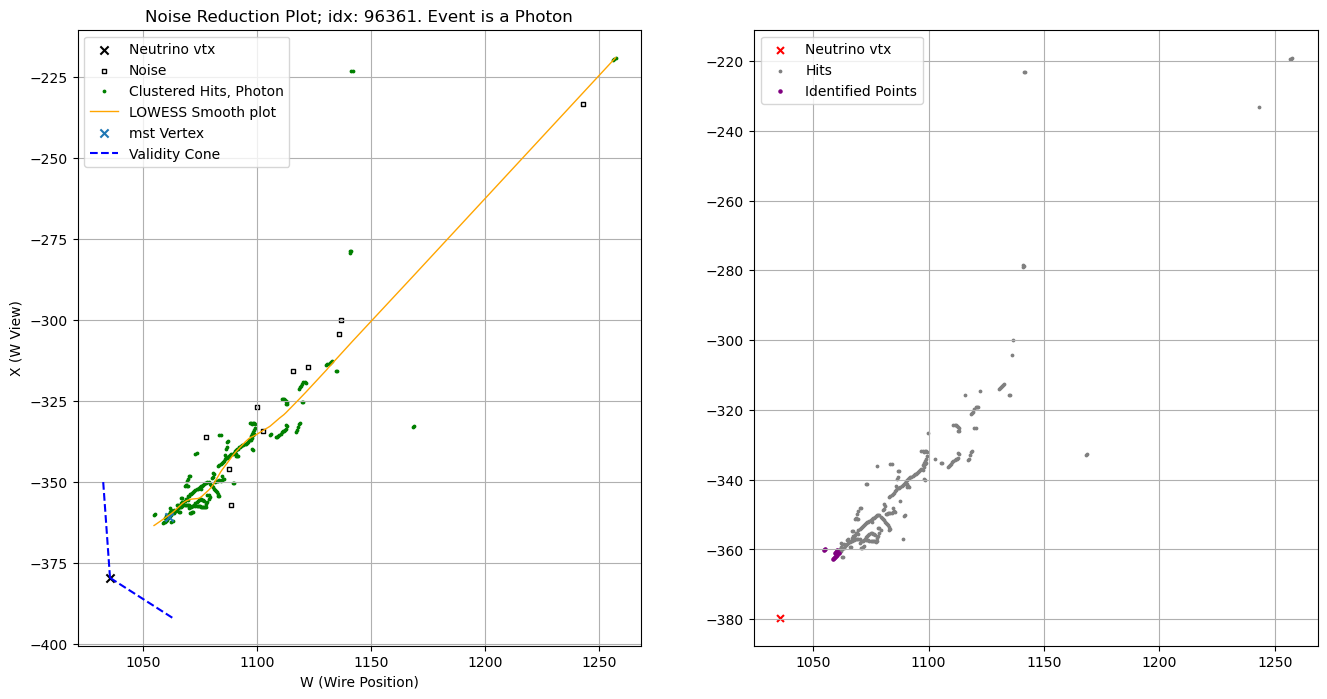

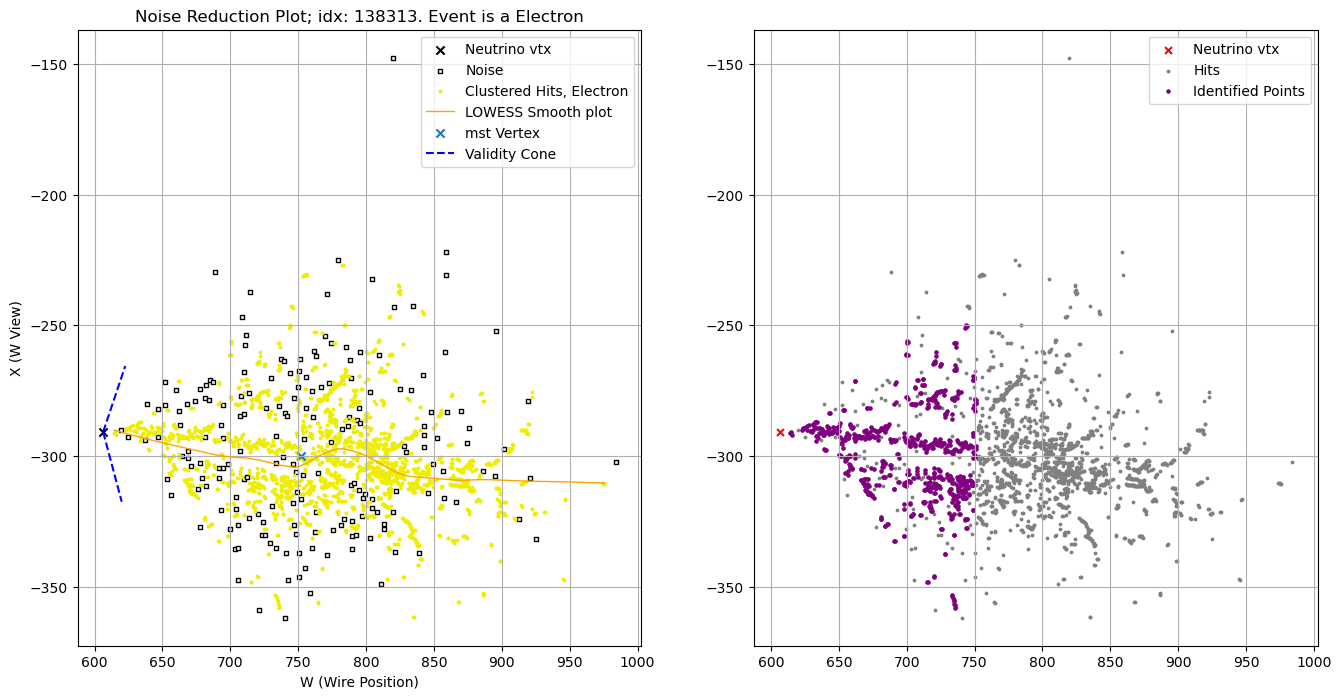

In [15]:
random_indices = random.sample(range(len(showers_0)), 20)

for i in random_indices:
    dEdx_points(cheated_0, showers_0[i], 2*np.pi/3, True)